# Imports

In [5]:
%matplotlib inline

import os
import corner
import emcee
import numpy as np
import matplotlib.pyplot as plt
import model_flux_ratio as mfr

from astropy.table import Table
from matplotlib.ticker import MaxNLocator

# Load Leo P

In [6]:
flux_ratios = Table.read(os.getcwd()+'/LeoP', format='ascii', delimiter=' ')

In [7]:
flux_ratios

Wavelength,Species,Flux Ratio,Flux Ratio Errors,EW,EW Errors
float64,str15,float64,float64,float64,float64
3890.166,hydrogen+helium,0.175,0.007,16.3,1.6
4027.328,helium,0.011,0.007,1.0,0.1
4102.891,hydrogen,0.246,0.006,26.5,2.7
4341.684,hydrogen,0.431,0.009,54.6,5.5
4472.755,helium,0.033,0.006,4.5,0.5
4862.721,hydrogen,1.0,0.02,183.2,18.3
5877.299,helium,0.103,0.004,30.2,3.0
6564.612,hydrogen,2.949,0.059,1222.0,122.0
6679.994,helium,0.03,0.003,14.3,1.4


# MCMC

## Setup

In [8]:
# Names of wavelengths of interest
y_names = ['HeI3890', 'HeI4027', 'Hd', 'Hg', 'HeI4472', 'Hb', 'HeI5877', 'Ha', 'HeI6679', 'HeI7067']

# Balmer and Helium lines of interest for MCMC
balmer_lines = np.array([6564.612, 4862.721, 4341.684, 4102.891]) # Ha, Hb, Hg, Hd
helium_lines = np.array([7067.198, 6679.994, 5877.299, 4472.755, 4027.328, 3890.151])

emis_lines = np.sort(np.concatenate((balmer_lines, helium_lines)))


In [28]:
# Measured data from spectra
EWs_meas = np.array(flux_ratios['EW'])
EW_errors = np.array(flux_ratios['EW Errors'])
EW_Hb = flux_ratios['EW'][np.where(flux_ratios['Wavelength'] == 4862.721)[0]]

y = np.array(flux_ratios['Flux Ratio'])
y_error = np.array(flux_ratios['Flux Ratio Errors'])
x = np.zeros(y.size)

In [29]:
EWs = np.random.normal(EWs_meas, EW_errors)

In [32]:
EWs

array([1.55797284e+01, 8.75794867e-01, 2.73456123e+01, 5.86513752e+01,
       4.46694613e+00, 1.77335082e+02, 3.44989247e+01, 1.19557335e+03,
       1.53656162e+01, 1.44811619e+01])

## Range of parameters

In [12]:
# Range of values for 8 parameters: y_plus, temp, dens, c_Hb, a_H, a_He, tau_He, xi
min_y_plus, max_y_plus = 0.05, 0.1  # fraction of singly ionized He; y+ = He+/H+
min_temp, max_temp = 5000, 25000  # electron temperature (K)
min_log_dens, max_log_dens = 0, 3  # log10(electron density) (cm^-3)
min_c_Hb, max_c_Hb = 0, 0.5  # reddening
min_a_H, max_a_H = 0, 10  # underlying stellar H absorption (Angstroms)
min_a_He, max_a_He = 0, 4  # underlying stellar HeI absorption (Angstroms)
min_tau_He, max_tau_He = 0, 5  # optical depth; range of values from Izotov & Thuan 2010
min_log_xi, max_log_xi = -6, -0.0969 # equals to xi=0-0.8; ratio of neutral hydrogen to singly ionized hydrogen densities; xi = n(HI)/n(HII)

In [14]:
xi = 10**-4
temp = 17200
dens = 1
c_Hb = 0.1
a_H = 1.02
a_He = 0.34
tau_He = 0.00
y_plus = 0.0837
EW_Hb = 183.2

In [22]:
model_flux = np.zeros(11) # 11 emission line fluxes we want to model

# Some values, calculated at Hbeta, for later use
collisional_to_recomb_Hbeta = mfr.hydrogen_collision_to_recomb(xi, balmer_lines[1], temp)
f_lambda_at_Hbeta = mfr.f_lambda_avg_interp(balmer_lines[1])

for w in range(len(emis_lines)):
# Determine if working with hydrogen or helium line; within 3 Angstroms is arbitrary but should cover difference in vacuum vs air wavelength
    nearest_wave = emis_lines[np.where(np.abs(emis_lines - emis_lines[w]) < 3)[0]][0]
    # The above line is redundant, but allows for cases where emis_lines[w] is some other array, say waves_of_interest[w], 
    # and not exactly at the wavelengths given in the emis_lines array (which is concatenated from arrays balmer_lines and helium_lines)

    # Any Balmer line besides the blended HeI+H8 line (H8 at 3890.166)
    if nearest_wave in balmer_lines and nearest_wave != 3890.166:
        line_species = 'hydrogen'

        emissivity_ratio = mfr.hydrogen_emissivity(emis_lines[w], temp, dens)
        a_H_at_wave = mfr.stellar_absorption(emis_lines[w], a_H, ion=line_species)
        collisional_to_recomb_ratio = mfr.hydrogen_collision_to_recomb(xi, emis_lines[w], temp)
        reddening_function = ( mfr.f_lambda_avg_interp(emis_lines[w]) / f_lambda_at_Hbeta ) - 1.            

        flux = emissivity_ratio * ( ( (EW_Hb + a_H)/(EW_Hb) ) / ( (EWs[w] + a_H_at_wave)/(EWs[w]) ) ) * \
                ( (1 + collisional_to_recomb_ratio) / (1 + collisional_to_recomb_Hbeta) ) * \
                10**-(reddening_function * c_Hb)

    # Any HeI line besides the blended HeI+H8 line (HeI at 3890.151)
    elif nearest_wave in helium_lines and nearest_wave != 3890.151:
        line_species = 'helium'

        emissivity_ratio = mfr.helium_emissivity(emis_lines[w], temp, dens)
        a_He_at_wave = mfr.stellar_absorption(emis_lines[w], a_He, ion=line_species)
        optical_depth_at_wave = mfr.optical_depth_function(emis_lines[w], temp, dens, tau_He)
        collisional_to_recomb_ratio = mfr.helium_collision_to_recomb(emis_lines[w], temp, dens)
        reddening_function = ( mfr.f_lambda_avg_interp(emis_lines[w]) / f_lambda_at_Hbeta ) - 1.

        flux = y_plus * emissivity_ratio * ( ( (EW_Hb + a_H)/(EW_Hb) ) / ( (EWs[w] + a_He_at_wave)/(EWs[w]) ) ) * \
                optical_depth_at_wave * ( (1 + collisional_to_recomb_ratio) / (1 + collisional_to_recomb_Hbeta) ) * \
                10**-(reddening_function * c_Hb)

    # The blended HeI+H8 line
    elif nearest_wave == 3890.151 or nearest_wave == 3890.166:
    # HeI 3890.151 contribution:
        line_species = 'helium'

        emissivity_ratio = mfr.helium_emissivity(emis_lines[w], temp, dens)
        a_He_at_wave = mfr.stellar_absorption(emis_lines[w], a_He, ion=line_species)
        optical_depth_at_wave = mfr.optical_depth_function(emis_lines[w], temp, dens, tau_He)
        collisional_to_recomb_ratio = mfr.helium_collision_to_recomb(emis_lines[w], temp, dens)
        reddening_function = ( mfr.f_lambda_avg_interp(emis_lines[w]) / f_lambda_at_Hbeta ) - 1.

        # Update input flux of blended line to only consist of HeI 3890
        a_H_at_wave = mfr.stellar_absorption(emis_lines[w], a_H, ion='hydrogen') # Underlying absorption at H8            
        frac_of_he = (( y[0] * (EWs[w] + a_H_at_wave)/(EWs[w]) ) - \
                                ( 0.104*((temp/1e4)**0.046) * 10**-(reddening_function * c_Hb) )) / y[0]
        EWs[w] = frac_of_he * EWs[w]
        
        print (EWs[w], frac_of_he)
        flux = y_plus * emissivity_ratio * ( ( (EW_Hb + a_H)/(EW_Hb) ) / ( (EWs[w] + a_He_at_wave)/(EWs[w]) ) ) * \
                optical_depth_at_wave * ( (1 + collisional_to_recomb_ratio) / (1 + collisional_to_recomb_Hbeta) ) * \
                10**-(reddening_function * c_Hb)
    #print (flux)

1.7471163050147291 0.8672559063103644


## Set up MCMC

In [54]:
def get_model(theta):
    y_plus, temp, log_dens, c_Hb, a_H, a_He, tau_He, log_xi = theta

    model_flux = np.zeros(11) # 11 emission line fluxes we want to model
    dens = 10 ** log_dens
    xi = 10 ** log_xi

    # Some values, calculated at Hbeta, for later use
    collisional_to_recomb_Hbeta = mfr.hydrogen_collision_to_recomb(xi, balmer_lines[1], temp)
#    f_lambda_at_Hbeta = mfr.f_lambda_avg_interp(balmer_lines[1])
    AHbeta_AV = mfr.reddening_coefficient(balmer_lines[1])

    for w in range(len(emis_lines)):
    # Determine if working with hydrogen or helium line; within 3 Angstroms is arbitrary but should cover difference in vacuum vs air wavelength
        nearest_wave = emis_lines[np.where(np.abs(emis_lines - emis_lines[w]) < 3)[0]][0]
        # The above line is redundant, but allows for cases where emis_lines[w] is some other array, say waves_of_interest[w], 
        # and not exactly at the wavelengths given in the emis_lines array (which is concatenated from arrays balmer_lines and helium_lines)

        # Any Balmer line besides the blended HeI+H8 line (H8 at 3890.166)
        if nearest_wave in balmer_lines and nearest_wave != 3890.166:
            line_species = 'hydrogen'

            emissivity_ratio = mfr.hydrogen_emissivity(emis_lines[w], temp, dens)
            a_H_at_wave = mfr.stellar_absorption(emis_lines[w], a_H, ion=line_species)
            collisional_to_recomb_ratio = mfr.hydrogen_collision_to_recomb(xi, emis_lines[w], temp)
#            reddening_function = ( mfr.f_lambda_avg_interp(emis_lines[w]) / f_lambda_at_Hbeta ) - 1.            
            reddening_function = (mfr.reddening_coefficient(emis_lines[w]) / AHbeta_AV ) - 1.

            flux = emissivity_ratio * ( ( (EW_Hb + a_H)/(EW_Hb) ) / ( (EWs[w] + a_H_at_wave)/(EWs[w]) ) ) * \
                    ( (1 + collisional_to_recomb_ratio) / (1 + collisional_to_recomb_Hbeta) ) * \
                    10**-(reddening_function * c_Hb)

        # Any HeI line besides the blended HeI+H8 line (HeI at 3890.151)
        elif nearest_wave in helium_lines and nearest_wave != 3890.151:
            line_species = 'helium'

#            emissivity_ratio = mfr.helium_emissivity(emis_lines[w], temp, dens)
            emissivity_ratio = mfr.helium_emissivity_2007(emis_lines[w], temp, dens)
            a_He_at_wave = mfr.stellar_absorption(emis_lines[w], a_He, ion=line_species)
            optical_depth_at_wave = mfr.optical_depth_function(emis_lines[w], temp, dens, tau_He)
            collisional_to_recomb_ratio = mfr.helium_collision_to_recomb(emis_lines[w], temp, dens)
#            reddening_function = ( mfr.f_lambda_avg_interp(emis_lines[w]) / f_lambda_at_Hbeta ) - 1.
            reddening_function = (mfr.reddening_coefficient(emis_lines[w]) / AHbeta_AV ) - 1.

            flux = y_plus * emissivity_ratio * ( ( (EW_Hb + a_H)/(EW_Hb) ) / ( (EWs[w] + a_He_at_wave)/(EWs[w]) ) ) * \
                    optical_depth_at_wave * ( (1 + collisional_to_recomb_ratio) / (1 + collisional_to_recomb_Hbeta) ) * \
                    10**-(reddening_function * c_Hb)

        # The blended HeI+H8 line
        elif nearest_wave == 3890.151 or nearest_wave == 3890.166:
        # HeI 3890.151 contribution:
            line_species = 'helium'
                
#            emissivity_ratio = mfr.helium_emissivity(emis_lines[w], temp, dens)
            emissivity_ratio = mfr.helium_emissivity_2007(emis_lines[w], temp, dens)
            a_He_at_wave = mfr.stellar_absorption(emis_lines[w], a_He, ion=line_species)
            optical_depth_at_wave = mfr.optical_depth_function(emis_lines[w], temp, dens, tau_He)
            collisional_to_recomb_ratio = mfr.helium_collision_to_recomb(emis_lines[w], temp, dens)
#            reddening_function = ( mfr.f_lambda_avg_interp(emis_lines[w]) / f_lambda_at_Hbeta ) - 1.
            reddening_function = (mfr.reddening_coefficient(emis_lines[w]) / AHbeta_AV ) - 1.

            # Update input flux of blended line to only consist of HeI 3890
            a_H_at_wave = mfr.stellar_absorption(emis_lines[w], a_H, ion='hydrogen') # Underlying absorption at H8            
            frac_of_he = (( y[0] * (EWs[w] + a_H_at_wave)/(EWs[w]) ) - \
                                    ( 0.104*((temp/1e4)**0.046) * 10**-(reddening_function * c_Hb) )) / y[0]
            EWs[w] = frac_of_he * EWs[w]
            
            flux = y_plus * emissivity_ratio * ( ( (EW_Hb + a_H)/(EW_Hb) ) / ( (EWs[w] + a_He_at_wave)/(EWs[w]) ) ) * \
                    optical_depth_at_wave * ( (1 + collisional_to_recomb_ratio) / (1 + collisional_to_recomb_Hbeta) ) * \
                    10**-(reddening_function * c_Hb)
            
        model_flux[w] = flux
        
    return frac_of_he, model_flux


In [33]:
# Define the probability function as likelihood * prior.
def lnprior(theta):
#    y_plus, temp, log_dens, c_Hb, a_H, a_He, tau_He, n_HI = theta
    y_plus, temp, log_dens, c_Hb, a_H, a_He, tau_He, log_xi = theta

    if min_y_plus <= y_plus <= max_y_plus and \
        min_temp <= temp <= max_temp and \
        min_log_dens <= log_dens <= max_log_dens and \
        min_c_Hb <= c_Hb <= max_c_Hb and \
        min_a_H <= a_H <= max_a_H and \
        min_a_He <= a_He <= max_a_He and \
        min_tau_He <= tau_He <= max_tau_He and \
        min_log_xi <= log_xi <= max_log_xi:
        return 0.0

    return -np.inf

def lnlike(theta, x, y, yerr):
    frac_of_he, model = get_model(theta)
    y[0] = y[0] * frac_of_he
    inv_sigma2 = 1.0/yerr**2
    
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))


def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + lnlike(theta, x, y, yerr)

## Set up sampler

In [34]:
ndim, nwalkers = 8, 100

pos = [np.array([np.random.uniform(min_y_plus, max_y_plus),
                np.random.uniform(min_temp, max_temp),
                np.random.uniform(min_log_dens, max_log_dens),
                np.random.uniform(min_c_Hb, max_c_Hb),
                np.random.uniform(min_a_H, max_a_H),
                np.random.uniform(min_a_He, max_a_He),
                np.random.uniform(min_tau_He, max_tau_He),
                np.random.uniform(min_log_xi, max_log_xi)]) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, y_error), threads=ndim)

## Run MCMC

In [35]:
print("Running MCMC...")
nmbr = 100
a = time.time()
for i, result in enumerate(sampler.run_mcmc(pos, nmbr, rstate0=np.random.get_state())):
    if True:#(i+1) % 100 == 0:
        print("{0:5.1%}".format(float(i) / nmbr))
print("Done.")
print((time.time()-a)/60.0, 'mins')

Running MCMC...
 0.0%
 1.0%
 2.0%
Done.
0.6036044200261433 mins


In [36]:
np.save("{0:s}_samples{1:d}.npy".format('test_deblend', nmbr), sampler.chain)

In [37]:
burnin = int(0.1*nmbr)

In [40]:
prenams = ['y+', 'temperature', '$log(n_{e})$', 'c(H\\beta)', '$a_{H}$', '$a_{He}$', '$\\tau_{He}', '$log(\\xi)$'] #'$n_{HI}$']
#input_vals = np.array([0.08, 18000, 2, 0.1, 1.0, 1.0, 1.0, -2]) #test_MCMC
#input_vals = np.array([0.0837, 17100, 0, 0.1, 0.94, 0.50, 0.0, 0]) #Leo P w/out HeI 5015
input_vals = np.array([0.0837, 17200, 0, 0.1, 1.02, 0.45, 0.0, 0]) #Leo P w/HeI 5015

print ('Best parameter values:')
y_plus_mcmc, temp_mcmc, log_dens_mcmc, c_Hb_mcmc, a_H_mcmc, a_He_mcmc, tau_He_mcmc, log_xi_mcmc = map(
    lambda v: (v[1], v[2] - v[1], v[1] - v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print ('y+', y_plus_mcmc)
print ('T', temp_mcmc)
print ('log(n_e)', log_dens_mcmc)
print ('c(Hb)', c_Hb_mcmc)
print ('a_H', a_H_mcmc)
print ('a_He', a_He_mcmc)
print ('tau_He', tau_He_mcmc)
print ('log(xi)', log_xi_mcmc)
print ('\n Input parameter values:')
print (input_vals)

Best parameter values:
y+ (0.07457677028673652, 0.013020580988471392, 0.014861758182985185)
T (13177.058857284417, 5769.754040448755, 3843.806416625679)
log(n_e) (1.5577390295206892, 0.8642143168640959, 0.9093170522856088)
c(Hb) (0.16900204337498353, 0.14508060825592994, 0.11081031400904504)
a_H (1.5823877876486492, 3.518851743115764, 1.1874008413307013)
a_He (1.9276591406960928, 0.9664786730863271, 0.9689765166297089)
tau_He (2.7862595608519904, 1.3494655332496914, 1.4750640466550617)
log(xi) (-2.6180609639117827, 1.289972683997572, 1.6338976578340403)

 Input parameter values:
[8.37e-02 1.72e+04 0.00e+00 1.00e-01 1.02e+00 4.50e-01 0.00e+00 0.00e+00]


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


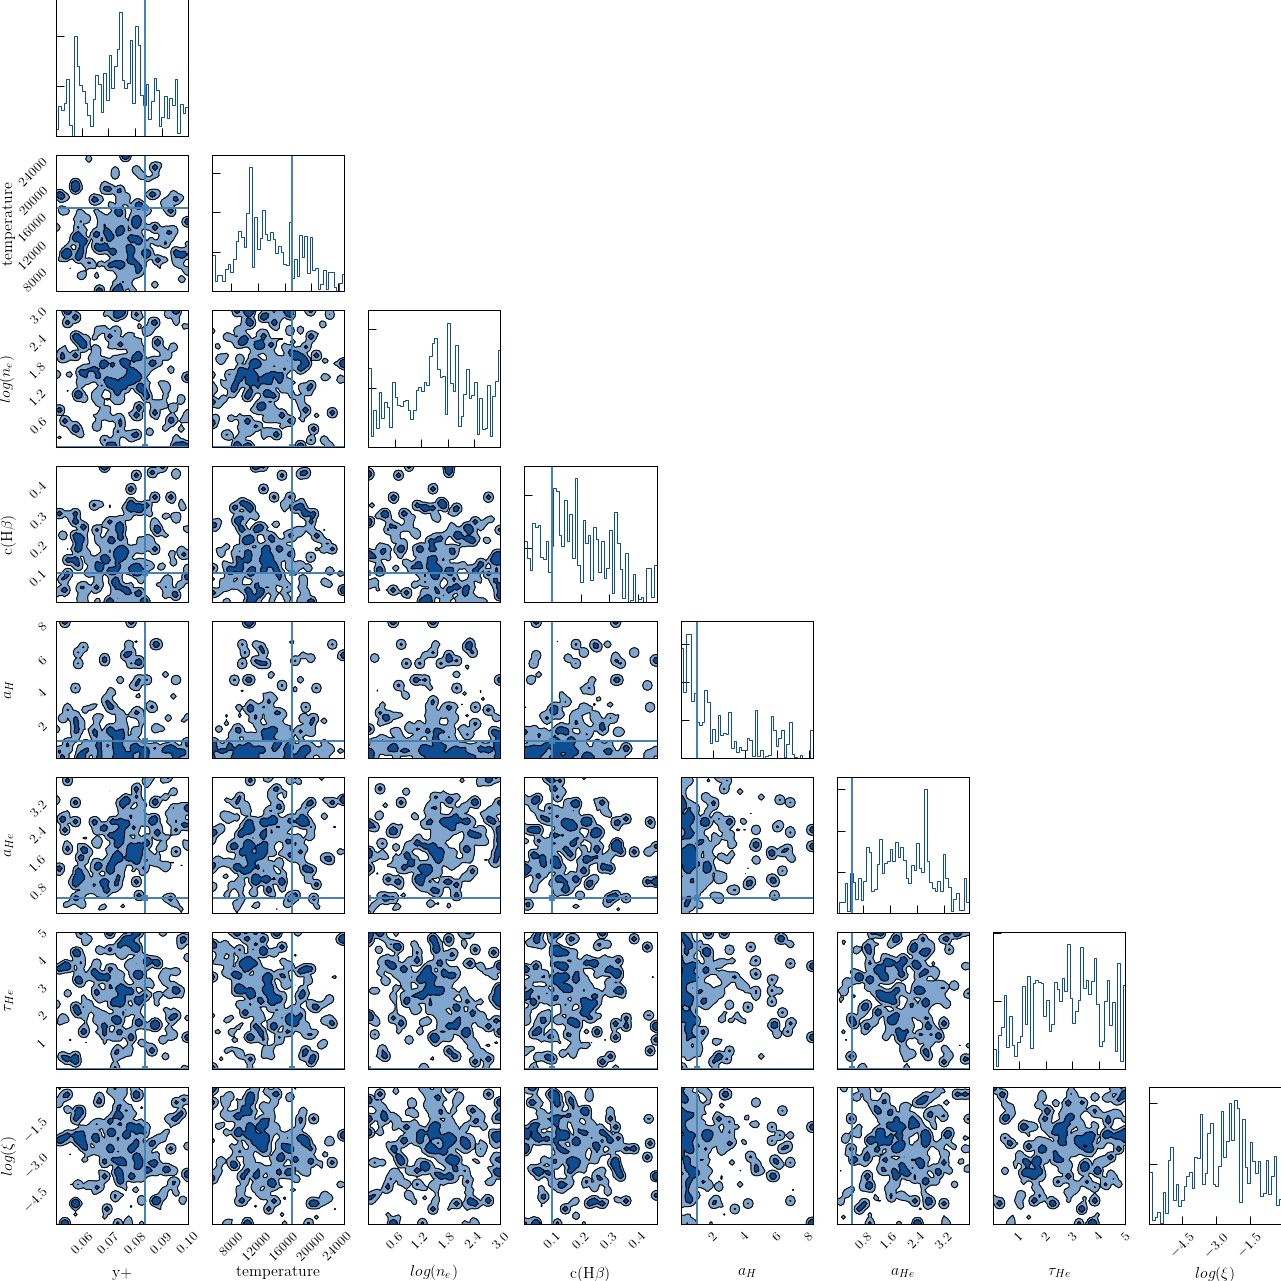

In [41]:
levels = 1.0 - np.exp(-0.5 * np.arange(1.0, 2.1, 1.0) ** 2)
contour_kwargs, contourf_kwargs = dict({}), dict({})
contour_kwargs["linewidths"] = [1.0, 1.0]
contourf_kwargs["colors"] = ((1, 1, 1), (0.502, 0.651, 0.808), (0.055, 0.302, 0.5727))
hist_kwargs = dict({})
hist_kwargs["color"] = contourf_kwargs["colors"][-1]
fig = corner.corner(samples, bins=[50, 50, 50, 50, 50, 50, 50, 50], levels=levels, plot_datapoints=False, fill_contours=True, smooth=1,
plot_density=False, contour_kwargs=contour_kwargs, contourf_kwargs=contourf_kwargs, hist_kwargs=hist_kwargs, labels=prenams, truths=input_vals)
fig.savefig('{0:s}_{1:d}walkers_{2:d}steps.pdf'.format('test_deblend_corner', nwalkers, nmbr), overwrite=True)

In [43]:
chains = np.load('test_deblend_samples100.npy')
samples = chains[:, burnin:, :].reshape((-1, ndim))

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


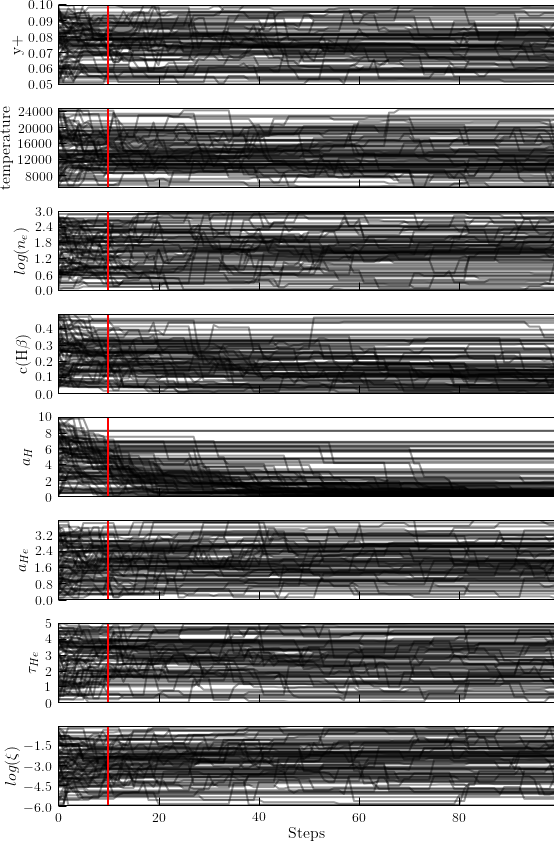

In [44]:
fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(8, 12))
for i in range(ndim):
    axes[i].plot(chains[:, :, i].T, color="k", alpha=0.4)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    axes[i].axvline(burnin, color='red')
    axes[i].set_ylabel(prenams[i])
axes[7].set_xlabel('Steps')
fig.tight_layout(h_pad=0.0)
fig.savefig('{0:s}_{1:d}walkers_{2:d}steps.pdf'.format('test_deblend_timeevol', nwalkers, nmbr), overwrite=True)
